<a href="https://colab.research.google.com/github/AlexTeixeira1/EEL891/blob/master/Regression_diamonds_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1OTvSyVoyittuafqup6E0IB1t_xsfTBAm)  Clique para executar online uma versão desse notebook

# Regressão para precificação de diamantes

## Análise exploratória e seleção de atributos

Inicialmente vamos importar o pandas e os arquivos de dados para uma análise exploratória

In [0]:
import pandas as pd

dataset = pd.read_csv('train.csv',index_col='id')
incognito = pd.read_csv('test.csv',index_col='id')

#-------------------------------------------------------------------------------
#Para reduzir as features
#-------------------------------------------------------------------------------
'''
dropar = ['x','y','z']

dataset = dataset.drop(dropar, axis = 1)
incognito = incognito.drop(dropar, axis = 1)
'''
#--------------------------------------------------------------------------------

y = dataset.iloc[:, -1].values


In [0]:
dataset.head()

,carat,cut,color,clarity,x,y,z,depth,table,price
id,,,,,,,,,,
20000,0.35,Very Good,G,VVS2,4.44,4.48,2.80,62.8,58.0,798
20001,0.70,Ideal,F,SI1,5.66,5.69,3.55,62.6,56.0,2089
20002,0.32,Ideal,F,VVS1,4.42,4.38,2.70,61.4,56.0,990
20003,0.30,Ideal,H,VVS2,4.32,4.35,2.67,61.7,54.2,631
20004,0.33,Premium,I,VVS2,4.41,4.47,2.76,62.2,59.0,579


Vemos que os dados para predição e treino diferem pela coluna *'price'* (nosso alvo) e os *id's* ordenados dos elementos, sendo que o conjunto para prever varia em 1-19999 e o de treino continua a partir daí. <br>Essa última informação poderia indicar que os conjuntos inicialmente eram um só e que talvez fossem ordenados de alguma forma, por exemplo temporal. Por essa questão, o próprio id foi hora incluído como feature e hora não.<br> Não houve mudança percepitível, logo, foi ignorado.<p>

Olhando para nossas colunas temos 3 categorias de atributos ordinais em string: <li>*cut*<li>*color*<li>*clarity* <p><p>Começaremos então por transformá-las em números, respeitando sua ordenação.

In [0]:
#função auxiliar para fazer o encoding
def encoder_ordem(dataframe, lista, ascend = True):
    j= 0
    if ascend != True:
        lista = lista[::-1]
    df = dataframe
    for i in lista:
        df = df.apply(lambda x: x.replace(i,j))
        j += 1
    return df
        

In [0]:
df = dataset

lista = ['D','E','F','G','H','I','J']
cuts = ['Fair','Good','Very Good','Premium','Ideal']
clar = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

df = encoder_ordem(df,lista, ascend=False)
df = encoder_ordem(df,cuts, ascend=True)
df = encoder_ordem(df,clar, ascend=True)


df.tail()
lista = ['D','E','F','G','H','I','J']
cuts = ['Fair','Good','Very Good','Premium','Ideal']
clar = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

incognito = encoder_ordem(incognito,lista, ascend=False)
incognito = encoder_ordem(incognito,cuts, ascend=True)
incognito = encoder_ordem(incognito,clar, ascend=True)


incognito.tail()

,carat,cut,color,clarity,x,y,z,depth,table
id,,,,,,,,,
19995,1.06,4,2,1,6.62,6.65,4.02,60.6,55.0
19996,0.53,4,5,3,5.23,5.26,3.20,61.0,57.0
19997,0.46,4,6,3,4.98,4.95,3.10,62.4,56.0
19998,0.59,4,3,5,5.35,5.39,3.34,62.2,56.0
19999,0.36,4,5,3,4.56,4.61,2.80,61.1,57.0


Com esse novo dataframe em mãos, agora é hora de ver como os dados se relacionam.
<br> Plotando a matriz de correlação e a scatter matrix:


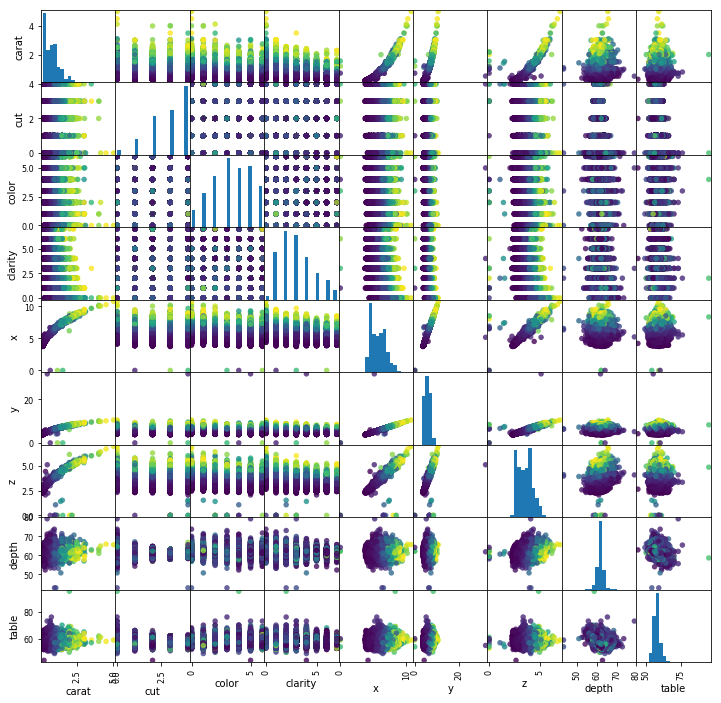

In [0]:
attributes = df.iloc[:, :-1]
target     = df.iloc[:, -1]
foo = pd.plotting.scatter_matrix(
        attributes, 
        c=y, 
        figsize=(12, 12),
        marker='o',
        hist_kwds={'bins': 20},
        s=30, 
        alpha=.8,
)

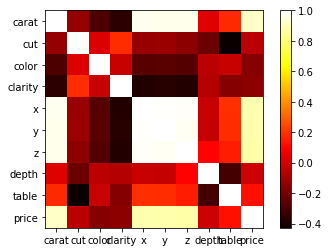

In [0]:
 import matplotlib.pyplot as plt  
 import matplotlib as mpl  
 corr = df.corr()  
 plt.imshow(corr, cmap='hot', interpolation='none')  
 plt.colorbar()  
 plt.xticks(range(len(corr)), corr.columns)  
 plt.yticks(range(len(corr)), corr.columns);  
 plt.show()

Pela scatter matrix vemos algumas features só tem poder de predição aplicadas em cima de outras.<br>
Pela matriz correlação, fica claro que as 3 dimenções *x,y,z* do diamante são fortemente correcionadas entre si, e com o peso. Faz sentido já que diamantes seguem uma forma semelhante, não se tornando muito achatados ou extremamente alongados.<p>
   <p> Como essa relação é forte e o peso é o mais correlato ao preço, selecionei apenas ele no primeiro teste.
    <br> Outras variações da performance consideradas foram de manter apenas cada uma das outras 3 dimenções. 
    <br> Também foram consideradas as variações de incluir ou não as colunas *'depth'* e *'table'*, uma vez que são obtidas com uma combinação mais complexa das dimenções.
    <p>
    <p> A escolha inicial de reduzir as dimenções do problema veio a perder por uma pequena margem RMSPE de ~0.015 para o método com todas as características. <br>Para a competição que prioriza o ranking de desempenho, mantive as features, mas poderia ser considerada uma escolha de produção mais adequada manter a redução.

## Aplicando um Modelo

Aqui deixei uma fração de 10% do conjunto de amostra para teste

In [0]:
X = df.iloc[:, :-1].values
Incg = incognito.iloc[:,:].values

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = 0.1
)

### A escolha do modelo de regressão 
Vem das características encontradas nos dados. Não temos poder preditivo suficiente nas relações lineares, então foram testados os modelos de RandomForest e GradientBoost, este ganhou após ajustes de hiperparâmetros.

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
forest  = GradientBoostingRegressor(max_depth=8,
                                    learning_rate=0.1, 
                                    random_state=2019)
forest.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=2019, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Prever para os conjuntos de treinamento e de teste

In [0]:
y_pred_train = forest.predict(X_train)
y_pred_test  = forest.predict(X_test )
y_pred_Incg  = forest.predict(Incg )

###  Verificar desempenho do regressor

Segundo o critério usado para o score, RMSPE:

In [0]:
import numpy as np
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [0]:
rmse_teste  = rmspe(y_test , y_pred_test)
print('\nDesempenho no conjunto de treinamento:')
print('RMSPE   = %.3f' %                     rmspe(y_train, y_pred_train) )

print('\nDesempenho no conjunto de teste:')
print('RMSPE   = %.3f' %                     rmspe(y_test , y_pred_test) )



Desempenho no conjunto de treinamento:
RMSPE   = 0.074

Desempenho no conjunto de teste:
RMSPE   = 0.093


## Salvando a previsão

Por fim, salvar as respostas com id em um novo dataframe e exportá-lo para csv com a pontuação do teste para organizar mais tarde os modelos avaliados.

In [0]:
respostas = pd.DataFrame(y_pred_Incg,columns=['price'])

a = []
for i in range(20000):
    a+=[i]
    
a = np.array(a)
inde = pd.DataFrame(a, columns=['id'])
result = pd.concat([inde, respostas], axis=1)
result.head()

,id,price
0,0,14772.323946
1,1,5073.948799
2,2,2589.285572
3,3,4824.780001
4,4,2452.985642


In [0]:
result.to_csv('%.3f diamante-regression.csv' %rmse_teste, index = None)